In [1]:
import comet_ml

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


import os
import time
import IPython

import h5py
import mitdeeplearning as mdl

import functools
from tqdm import tqdm

2024-05-29 15:43:53.723755: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 15:43:53.723815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 15:43:53.790310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 15:43:53.922566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Before Running This Notebook:
### Create a .txt file called "comet_key"
### Paste your Comet API Key into comet_key.txt

In [109]:
# Package Parameters
CWD = os.getcwd()
print(CWD)

key_file = open(f'{CWD}/comet_key.txt')
COMET_API_KEY = key_file.read()
matplotlib.rcParams['font.family'] = "Times New Roman"


current_time = time.gmtime(time.time())
print(current_time)

### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if 'experiment' in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

### Ensure training on GPU ###
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

/mnt/e/AP Research/Polished-Capstone
time.struct_time(tm_year=2024, tm_mon=5, tm_mday=29, tm_hour=23, tm_min=36, tm_sec=27, tm_wday=2, tm_yday=150, tm_isdst=0)


# Data Loading

In [110]:
def load_dataset(path_to_training_data):
    with h5py.File(path_to_training_data) as f:
        # Print the keys (names) of all groups and datasets in the file
        print("Keys:", list(f.keys()))

        # Iterate through each key and print more detailed information
        for key in f.keys():
            if isinstance(f[key], h5py.Dataset):
                print(f"Dataset: {key}")
                print("  Shape:", f[key].shape)
                print("  Data type:", f[key].dtype)
                
    ### Instantiate Loader Function ###
    return mdl.lab2.TrainingDatasetLoader(path_to_training_data)

In [111]:
def visualize_dataset(path_to_training_data, loader):
    ### Visualize our data ###
    number_of_training_examples = loader.get_train_size()
    print(number_of_training_examples)
    (images, labels) = loader.get_batch(100)
    malignant_images = images[np.where(labels==1)[0]]
    benign_images = images[np.where(labels==0)[0]]

    idx_malignant = 23
    idx_benign = 9

    plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(malignant_images[idx_malignant])
    plt.title("Malignant"); plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.imshow(benign_images[idx_benign])
    plt.title("Benign"); plt.grid(False)

In [112]:
### Instantiate Loaders ###
loader_ISIC = load_dataset(f'{CWD}/datasets/split/train_ISIC.h5')
loader_ISIC_DiDI = load_dataset(f'{CWD}/datasets/split/train_ISIC_DiDI.h5')
loader_ISIC_ArGI = load_dataset(f'{CWD}/datasets/split/train_ISIC_ArGI.h5')
loader_test = load_dataset(f'{CWD}/datasets/split/test_ISIC_DiDI.h5')

Keys: ['images', 'labels']
Dataset: images
  Shape: (1581, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (1581, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split/train_ISIC.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (2106, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2106, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split/train_ISIC_DiDI.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (2106, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2106, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split/train_ISIC_ArGI.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (526, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (526, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split/test_ISIC_DiDI.h5
Loading data into memory...


1581
2106
2106


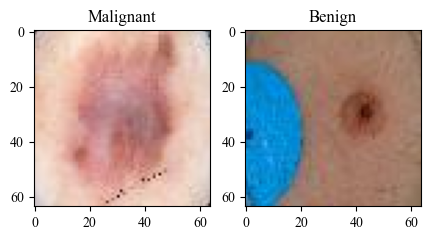

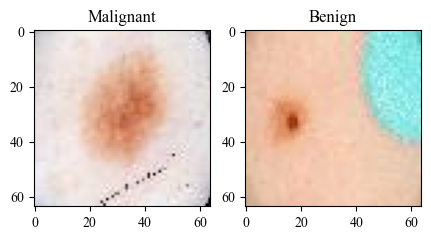

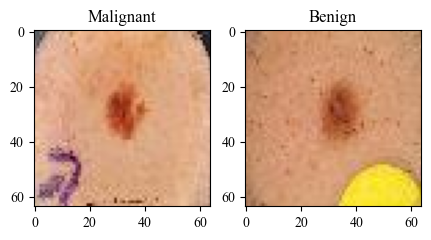

In [113]:
### Visualize Training Datasets ###
visualize_dataset(f'{CWD}/datasets/train_ISIC.h5', loader_ISIC)
visualize_dataset(f'{CWD}/datasets/train_ISIC_DiDI.h5', loader_ISIC_DiDI)
visualize_dataset(f'{CWD}/datasets/train_ISIC_ArGI.h5', loader_ISIC_ArGI)

# Create Model Architectures

In [114]:
### Standard CNN ###

# Helper Functions
def resize_images(x):
    return tf.image.resize(x, (64, 64))

# CNN Function
def make_standard_ResNet50_V2(n_outputs = 1):
    
    Resize = tf.keras.layers.Lambda(resize_images)
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    ResNet50V2 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
        input_tensor=None,
        input_shape=(64,64,3),
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    ResNet50V2 = tf.keras.Model(inputs = ResNet50V2.layers[1].input, 
                                outputs = ResNet50V2.layers[-1].output)

    model = tf.keras.Sequential()
    
    model.add(Resize)
    model.add(ResNet50V2)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_outputs, activation=None))

    return model

In [115]:
### DB-VAE ###

### Define Decoder Network ###
latent_dim = 100 # number of latent variables
n_filters = 12 
def make_decoder_network():
    """
    Layer Types, Functional Definition
    """
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape 
    BatchNormalization = tf.keras.layers.BatchNormalization
    LeakyReLU = tf.keras.layers.LeakyReLU
    # Decoder
    decoder = tf.keras.Sequential([
        Dense(units=4*4*6*n_filters),
        Reshape(target_shape=(4,4,6*n_filters)),

        Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    
    return decoder

### DB_VAE Helper Functions ###

### VAE Reparameterization ###
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

### Defining the VAE loss function ###
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

### Loss function for DB-VAE ###
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  malignance_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      malignance_indicator * vae_loss
  )
  return total_loss, classification_loss

### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_ResNet50_V2(num_encoder_dims)
    self.decoder = make_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit
  
### DB_VAE Training Helper Functions ###

# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)
    training_sample_p = np.zeros(mu.shape[0])
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [116]:
### Set Training Hyperparamters ###

### Hyperparameters for CNN Training ###
params_CNN = dict( 
  batch_size = 32,
  num_epochs = 50,
  learning_rate = 5e-4,
)

### Hyperparameters for DB-VAE Training ###
params_DB_VAE = dict(
    batch_size = 32,
    num_epochs = 50, 
    learning_rate = 5e-4,
    latent_dim = 100,
)

# Training

In [117]:
def experiment_base_CNN(model_num, data_loader, params):

    ### Instantiate new model ###
    model = make_standard_ResNet50_V2()

    ### Train the standard CNN ###
    experiment = create_experiment(f"{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_Model_{model_num}", params)

    optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
    loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
    plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

    @tf.function
    def standard_train_step(x, y):
        with tf.GradientTape() as tape:
            # feed the images into the model
            logits = model(x)
            # Compute the loss
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

        # Backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    # The training loop!
    step = 0
    for epoch in range(params["num_epochs"]):
        for idx in tqdm(range(data_loader.get_train_size()//params["batch_size"])):
            # Grab a batch of training data and propagate through the network
            x, y = data_loader.get_batch(params["batch_size"])

            loss = standard_train_step(x, y)

            # Record the loss and plot the evolution of the loss as a function of training
            loss_history.append(loss.numpy().mean())
            plotter.plot(loss_history.get())

            experiment.log_metric("loss", loss.numpy().mean(), step=step)
            step += 1

    ### Obtain Loss Values Over Epoch ###
    steps = len(loss_history.get())
    print(steps)

    epochs = np.uint8(params['num_epochs'])
    batches_per_epoch = np.uint8(steps/epochs)

    loss_hist = np.zeros((steps,1))
    for i in range(steps):
        loss_hist[i] = loss_history.get()[i]
    loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

    row_means = np.zeros((epochs))
    for i in range(epochs):
        row_means[i] = loss_hist.sum(axis=1)[i]

    row_means = row_means/batches_per_epoch
    for mean in row_means:
        print(mean)

    experiment.end()
    return model, row_means

In [118]:
def experiment_DB_VAE(model_num, data_loader, params):
    
    ### Instantiate new model ###
    model = DB_VAE(params["latent_dim"])
    
    experiment = create_experiment(f"{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_Model_{model_num}", params)

    optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

    @tf.function
    def debiasing_train_step(x, y):
        with tf.GradientTape() as tape:
            y_logit, z_mean, z_logsigma, x_recon = model(x)
            loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    all_imgs = data_loader.get_all_train_faces()

    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

    loss_history_2 = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
    # The training loop -- outer loop iterates over the number of epochs
    step = 0
    for i in range(params["num_epochs"]):

        IPython.display.clear_output(wait=True)
        print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))
        p_lesions = get_training_sample_probabilities(all_imgs, model)

        for j in tqdm(range(data_loader.get_train_size() // params["batch_size"])):
            # load a batch of data
            (x, y) = data_loader.get_batch(params["batch_size"], p_pos=p_lesions)

            # loss optimization
            loss = debiasing_train_step(x, y)
            experiment.log_metric("loss", loss.numpy().mean(), step=step, epoch=i+1)
            loss_history_2.append(loss.numpy().mean())
            # plot the progress every 200 steps
            if j % 500 == 0:
                mdl.util.plot_sample(x, y, model)

            step += 1

    ### Obtain Loss Values Over Epoch ###
    steps = len(loss_history_2.get())
    print(steps)

    epochs = np.uint8(params['num_epochs'])
    batches_per_epoch = np.uint8(steps/epochs)

    loss_hist = np.zeros((steps,1))
    for i in range(steps):
        loss_hist[i] = loss_history_2.get()[i]
    loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

    row_means = np.zeros((epochs))
    for i in range(epochs):
        row_means[i] = loss_hist.sum(axis=1)[i]

    row_means = row_means/batches_per_epoch
    for mean in row_means:
        print(mean)

    experiment.end()

    return model, row_means

In [119]:
def graph_loss(model_num, row_means, epochs):
    epochs_range = np.arange(1,epochs+1)
    plt.figure(figsize=(8,7))
    size_axis_titles = 16
    size_title = 18
    size_legend = 14
    plt.xlabel("Epoch", fontsize=size_axis_titles)
    plt.ylabel("Loss", fontsize=size_axis_titles)
    plt.axis([1, 50, 0, 2.5])
    plt.plot(epochs_range, row_means, label='Training')
    plt.legend(loc='upper right', fontsize=size_legend)
    plt.title(f'Training Loss for Model {model_num}', fontsize=size_title)
    plt.show()

In [120]:
### Set Testing Hyperparameters ###
params_test = dict(
    runs = 30,
    batch_size = 256,
)

In [121]:
def evaluate(model, runs, batch_size):
    ### Evaluation of model on test dataset (n = 526) ###

    ### Confusion Matrices ###
    """
    | TP  FP |
    | FN  TN |
    where TP is true positive
    FP is false positive
    FN is false negative
    TN is true negative
    Precision equals TP / (TP + FP)
    Recall equals TP / (FN + TP)
    harmonic mean of precision and recall gives F1 score
    F1 = 2 * (precision * recall) / (precision + recall)

    Sensitivity: TP / (FN + TP)

    Specificity: TN / (FP + TN)
    """

    from sklearn.metrics import confusion_matrix

    for i in range(runs):
        # print(batch_x.shape) # (256, 64, 64, 3), these are the test images
        # print(batch_y.shape) # (256, 1), these are the test labels
        (batch_x, batch_y) = loader_test.get_batch(batch_size)

        ### Predict on the test batch ###
        """
        returns an EagerTensor when it's a DB-VAE but a numpy array when it's a CNN. 
        I don't know why.
        """
        
        y_pred_standard = tf.round(tf.nn.sigmoid(model.predict(batch_x)))
        acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
        accuracies[i] = acc_standard.numpy()

        cm = confusion_matrix(batch_y, y_pred_standard)

        assert batch_size == np.sum(cm)
        
        tp = cm[0,0]
        fp = cm[0,1]
        fn = cm[1,0]
        tn = cm[1,1]
        
        accuracy, specificity, sensitivity, precision, recall, f1score = 0, 0, 0, 0, 0, 0

        ### Compute Accuracy: TP + FP divided by batch_size ###
        assert np.sum(cm) != 0
        accuracy = float(tp + tn) / float(batch_size)

        ### Compute Sensitivity: TP divided by FN + TP ###
        ### Sensitivity is the same as Recall ###
        assert fn + tp != 0
        sensitivity = float(tp) / float(tp + fn)
        recall = sensitivity

        ### Compute Specificity: TN divided by FP + TN ###
        assert tn + fp != 0
        specificity = float(tn) / float(fp + tn)

        ### Compute Precision: TP divided by TP + FP ###
        assert tp + fp != 0
        precision = float(tp) / float(tp + fp)

        ### Compute F1-Score: two times the product of precision and recall, divided by the sum of precision and recall ###
        assert precision + recall != 0
        f1score = 2 * precision * recall / float(precision + recall)

        print(cm)
        assert accuracies[i] == accuracy
        print(f'accuracy: {accuracy}')
        print(f'specificity: {specificity}')
        print(f'sensitivity: {sensitivity}')
        print(f'precision: {precision}')
        print(f'F1-score: {f1score}')
        break

    return accuracies.mean()

In [122]:
print("model 1")
evaluate(model_1, 256)
print("\n")
print("model 2")
evaluate(model_2, 256)
print("\n")
print("model 3")
evaluate(model_3, 256)
print("\n")

model 1


TypeError: evaluate() missing 1 required positional argument: 'batch_size'

In [ ]:
print("model 4")
evaluate(model_4, 256)
print("\n")
print("model 5")
evaluate(model_5, 256)
print("\n")
print("model 6")
evaluate(model_6, 256)
print("\n")


model 4
[[104  24]
 [ 83  45]]
accuracy: 0.58203125
specificity: 0.6521739130434783
sensitivity: 0.5561497326203209
precision: 0.8125
F1-score: 0.6603174603174604


model 5
[[106  22]
 [ 88  40]]
accuracy: 0.5703125
specificity: 0.6451612903225806
sensitivity: 0.5463917525773195
precision: 0.828125
F1-score: 0.6583850931677019


model 6
[[99 29]
 [77 51]]
accuracy: 0.5859375
specificity: 0.6375
sensitivity: 0.5625
precision: 0.7734375
F1-score: 0.6513157894736842




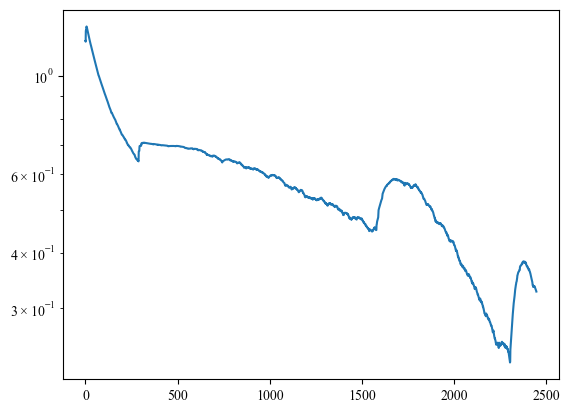

100%|██████████| 49/49 [00:04<00:00, 11.76it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-29-model-1/b49700b8cca2470c93465b5173da0af8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [2450] : (0.021380500867962837, 8.265974998474121)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_ep

2450
1.1946519688427286
1.003402643179619
0.8711437235929765
0.7801777416269493
0.7133943267718684
0.6645765753030842
0.7040449226675383
0.7022003821624079
0.6982160919530134
0.6952668207725045
0.6935865536823546
0.6864486149141318
0.6816753800832969
0.6664208388138588
0.6554308065593865
0.6460971028569262
0.6410806954735275
0.6274980292323882
0.6185323980731061
0.6070914285411046
0.5953252239159706
0.5863017837824568
0.5634762649908593
0.5545314461767268
0.5363276372204725
0.5279820652778192
0.5206480853707258
0.5106412661411689
0.49360987085976327
0.47961343088433045
0.4741778884593025
0.4521559036637925
0.49555842338209544
0.5694658808326957
0.5830213611584425
0.5712786778057911
0.5621173120406684
0.5291088857789007
0.48954356674079796
0.4581694179076643
0.4248161388984276
0.3831321909826208
0.3529155847733504
0.3204658106322879
0.286291819378796
0.2542743006179579
0.24447007456307498
0.3109056038106031
0.37558118105212496
0.3451121120604457


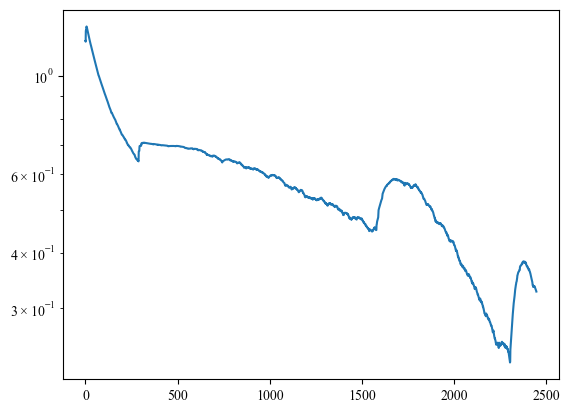

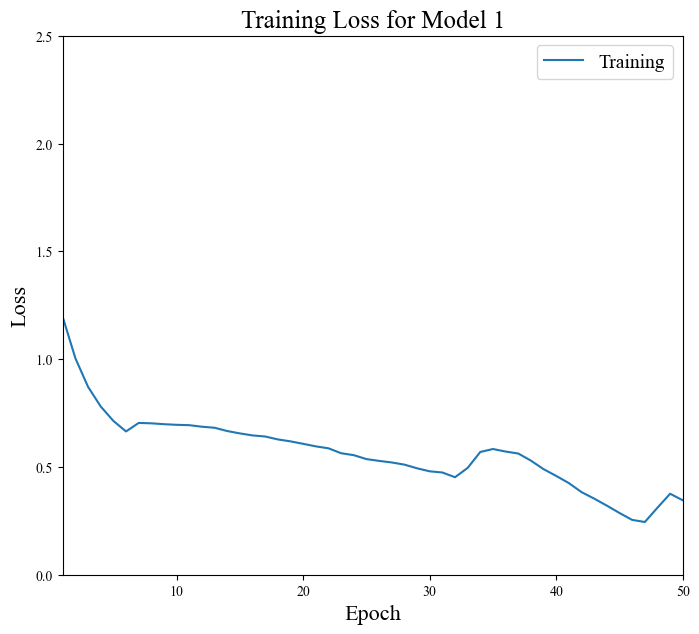

8/8 [==============================] - 0s 14ms/step
0.615625
0.016774148869987415


In [ ]:
model_1, row_means_1 = experiment_base_CNN(1, loader_ISIC, params_CNN)
graph_loss(1, row_means_1, params_CNN["num_epochs"])

results[1-1, 0], results[1-1, 1] = evaluate(model_1)

model_1.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_1.keras")
tf.keras.backend.clear_session()

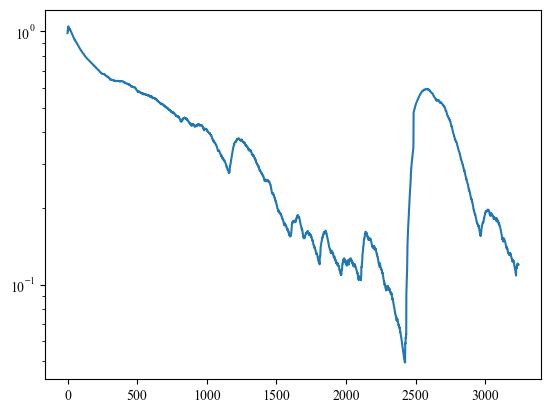

100%|██████████| 65/65 [00:05<00:00, 11.74it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-29-model-2/3cb4b09406c7487887b647b00e0f8ec8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3250] : (7.560739322798327e-05, 11.951597213745117)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_

3250
0.9755333052259126
0.8439954917455048
0.7606386856000634
0.6999336057182558
0.6592112625331746
0.6377356959120435
0.6240843562953152
0.5937067968204625
0.5658732311775807
0.5462864340868767
0.5146889284053017
0.4826074737389535
0.45379922401387796
0.43800030923382466
0.4251083237575837
0.40156721498077624
0.35021162826372265
0.2993388071732919
0.35360747764029643
0.3623676608696458
0.3236364793891506
0.27387804384546444
0.24024222577487808
0.19137443354061698
0.16649971979766068
0.17811240786162896
0.15759577970021854
0.1355653864430135
0.1531669505812592
0.12776998061797823
0.11946640950779269
0.12121780429104735
0.12598220822469924
0.14844758428326954
0.1208277531196483
0.09514198379002498
0.07133973638368533
0.12940374431130064
0.47659847786821075
0.5856648539494574
0.5560511170779708
0.5082828347418038
0.4149061582570337
0.3147872193065876
0.2289490863754109
0.17239919513321345
0.19156792675810871
0.17662271563988713
0.14198685274187203
0.1204643417071249


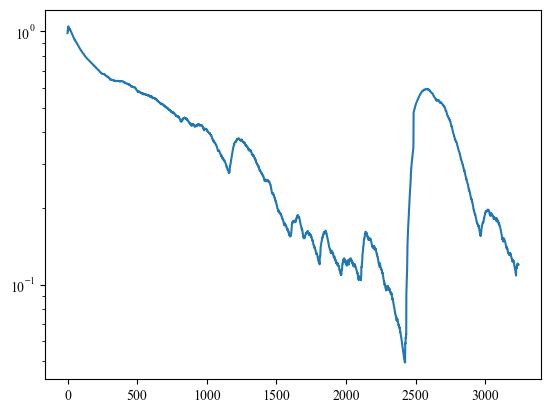

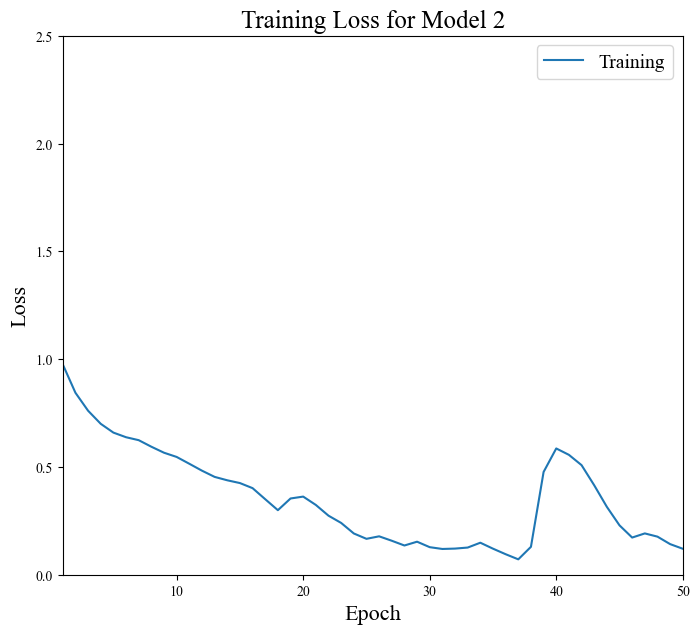

8/8 [==============================] - 0s 17ms/step
0.5970052083333334
0.01992017285756695


In [ ]:
model_2, row_means_2 = experiment_base_CNN(2, loader_ISIC_DiDI, params_CNN)
graph_loss(2, row_means_2, params_CNN["num_epochs"])

results[2-1, 0], results[2-1, 1] = evaluate(model_2)

model_2.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_2.keras")
tf.keras.backend.clear_session()

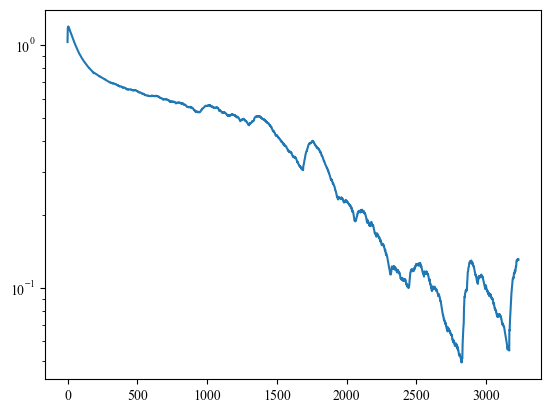

100%|██████████| 65/65 [00:05<00:00, 12.17it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-29-model-3/32092d4be60248e1952bcdab32c50486
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3250] : (1.2384967703837901e-05, 13.064408302307129)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam

3250
1.0841996295600107
0.897542286293979
0.7964681175083143
0.7445828190598595
0.7078682502795093
0.683229953757708
0.6606739718540537
0.6470572664328208
0.6249527811296094
0.6157525623459981
0.601228962315555
0.5843179628651208
0.5742993780444002
0.5526943636290588
0.5343547327436801
0.559721215963952
0.5459639942045362
0.5189816558860522
0.5086961775717169
0.4862498766120822
0.4901127421604844
0.49641884072543646
0.4542771707448966
0.40484011682466814
0.3636539386377383
0.32394004917555497
0.37062686424923114
0.37952993165561233
0.31872022409300443
0.2552250404786045
0.22878765067076973
0.20404129415258437
0.20384961455719217
0.18001493231977567
0.15640085169997778
0.1255221913991016
0.11488172976857886
0.107494288989578
0.1223807188405775
0.11400718601172555
0.09807860935632913
0.07672792446900736
0.06155175318916328
0.06610332091935443
0.12042689181275436
0.10902016367631713
0.09441363095465802
0.07763061914693727
0.06764249747927062
0.12126849792920218


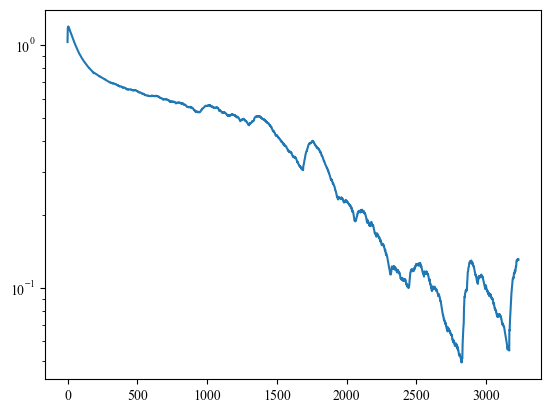

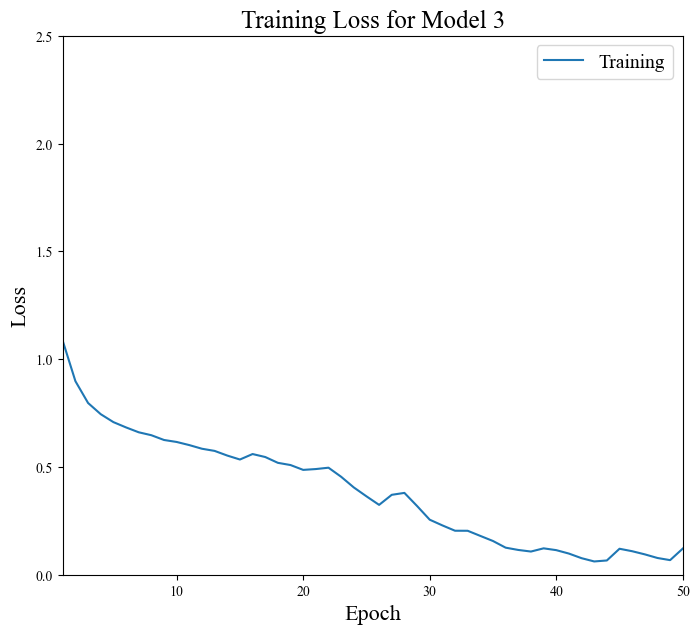

8/8 [==============================] - 0s 17ms/step
0.5704427083333333
0.015673211212006957


In [ ]:
model_3, row_means_3 = experiment_base_CNN(3, loader_ISIC_ArGI, params_CNN)
graph_loss(3, row_means_3, params_CNN["num_epochs"])

results[3-1, 0], results[3-1, 1] = evaluate(model_3)

model_3.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_3.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/49 [00:00<?, ?it/s]

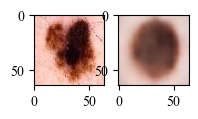

100%|██████████| 49/49 [00:04<00:00, 11.11it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-29-model-4/27554524b5a848c1a6f5364619ccbee4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [2450] : (0.052500754594802856, 3.0385582447052)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsi

2450
1.2027444451396567
1.0263287470222724
0.9139032151465376
0.8454707612911666
0.7950097428032966
0.724998795245925
0.670938067501001
0.626102165836807
0.5787772629141503
0.5487211426691702
0.5251060238014842
0.4980959619298171
0.47214178009687513
0.45194062792805834
0.4395936538095575
0.4286271868033927
0.4147599875183902
0.39954758801941326
0.3679172053967219
0.35292582115848625
0.34037884951743175
0.32099068777804834
0.2974912974314065
0.29472810076467776
0.2798690476580641
0.2528798396182415
0.2437089332105676
0.23424957347764966
0.23404518245941922
0.22091413116850186
0.2185261334209072
0.20364032901440388
0.18664179083651777
0.1868568588963864
0.17269041138791638
0.1569804115459928
0.15865527704294496
0.15290842204416935
0.14597480467609444
0.14576736516911393
0.13724686533380906
0.1226664467370949
0.11136378959204299
0.11083698824430516
0.11342395064775972
0.12371046889274707
0.12125109626531465
0.11978203973892192
0.13348161844744377
0.1298151904048243


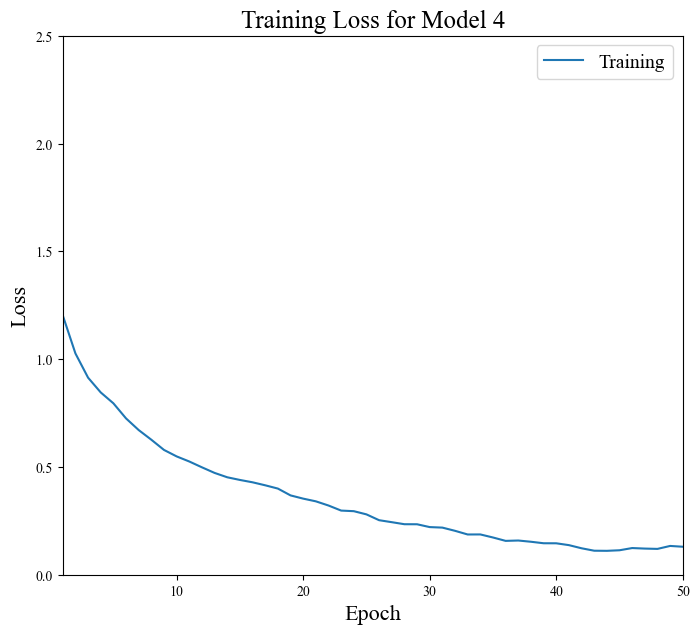

0.5817708333333333
0.015459189666308158


In [ ]:
model_4, row_means_4 = experiment_DB_VAE(4, loader_ISIC, params_DB_VAE)
graph_loss(4, row_means_4, params_DB_VAE["num_epochs"])

results[4-1, 0], results[4-1, 1] = evaluate(model_4)

model_4.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_4.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/65 [00:00<?, ?it/s]

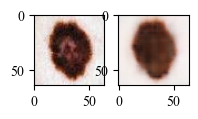

100%|██████████| 65/65 [00:05<00:00, 12.10it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-29-model-5/e49ac42e6439415ca731f99a42154aa9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3250] : (0.05864303559064865, 22.902542114257812)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_ep

3250
2.0054647794920375
1.4269595917469302
1.089215197495989
0.8861993158361879
0.7711134252501275
0.6924526914309463
0.644474479756062
0.6058707113838163
0.5756846312315912
0.5492799919411304
0.5259017676103929
0.4740866235839905
0.43609485748782634
0.41407101795576035
0.3931112275548976
0.3678380946061277
0.34501470816463403
0.30793740200783526
0.29036547731071893
0.2662824654831617
0.24604312751506582
0.24359500346626944
0.24779869069486743
0.23404849655252455
0.21832621912224276
0.21899933126706805
0.19766428880766282
0.18554069816342805
0.18697811555488028
0.17869482641613904
0.17661622747390784
0.17513019709233066
0.1711929855982476
0.1642579586526393
0.15058910313673093
0.13780548373874663
0.14133176497273067
0.13475170574996415
0.13543530413136912
0.1465905418046209
0.1395115667446607
0.14859185185721732
0.16037768532684446
0.16553265788555785
0.15759742119146347
0.15781628408216644
0.15314939849115217
0.16007341545925102
0.14653036125237298
0.13677951724999676


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 309 metrics, params and output messages


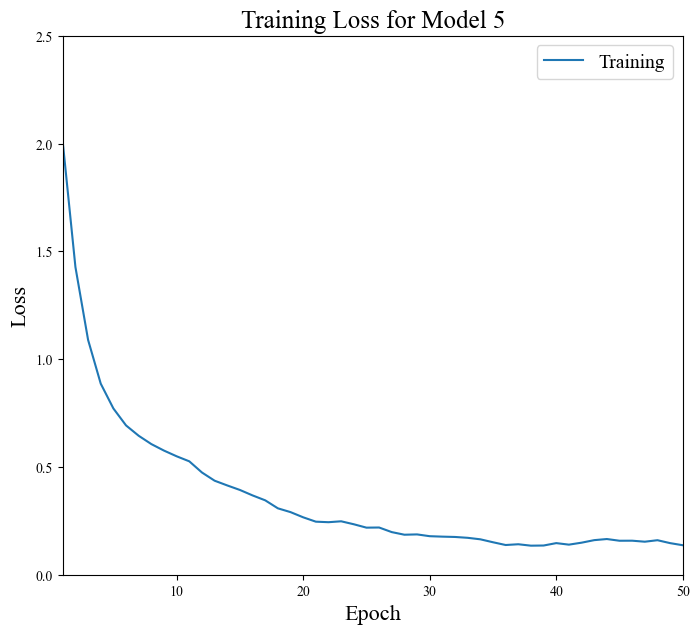

0.5876302083333333
0.019366054862727737


In [ ]:
model_5, row_means_5 = experiment_DB_VAE(5, loader_ISIC_DiDI, params_DB_VAE)
graph_loss(5, row_means_5, params_DB_VAE["num_epochs"])

results[5-1, 0], results[5-1, 1] = evaluate(model_5)

model_5.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_5.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/65 [00:00<?, ?it/s]

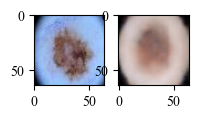

100%|██████████| 65/65 [00:05<00:00, 11.63it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-29-model-6/3e26e65b612c4a0db8d31e4d595f7b07
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3250] : (0.04733449965715408, 11.089241027832031)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_ep

3250
1.3364130264256453
1.044860597677076
0.8632430878031938
0.7512428491350894
0.685739812513857
0.6480012642111252
0.6247206948782256
0.5991872438844446
0.5737885039428822
0.5336483186930334
0.5066891409434249
0.47976473241787027
0.44499871905654403
0.41978112452258676
0.39439072363530664
0.3848593984177085
0.3580625731480927
0.33555217415282923
0.3139504210661652
0.2925546712399636
0.27364989466260964
0.2579687421388486
0.23684520237574716
0.21196800107497663
0.19289231001150772
0.1902084440725884
0.19504584616628803
0.17785502995740077
0.16363884946996796
0.16229592425457448
0.1491265073294419
0.1385215185136234
0.13754154956211634
0.14472510704158578
0.14389756026569858
0.1465860111734761
0.1330431008829285
0.12228052574687084
0.12963083029737948
0.14072362830945984
0.1317941367528742
0.12866190547610842
0.11858547027954211
0.11205625773748719
0.11413429671644412
0.11005830492970005
0.09881355712446706
0.09367682390157026
0.08491487098447487
0.0880635719753833


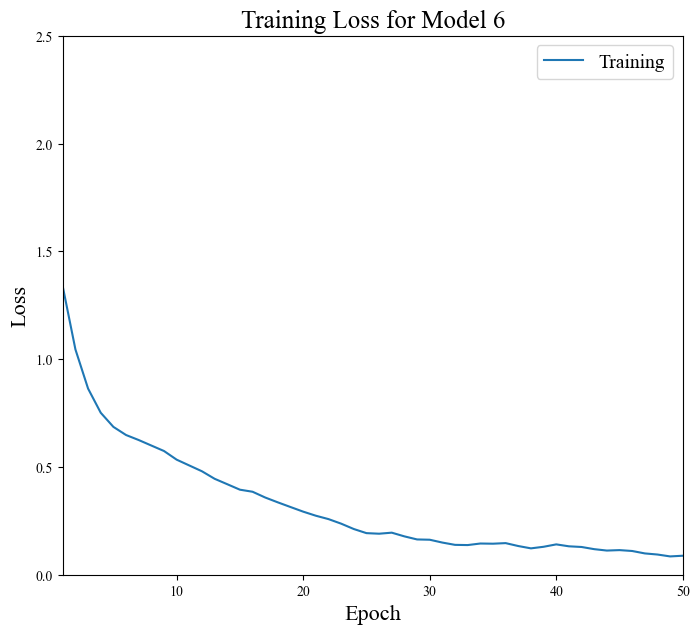

0.5803385416666667
0.019470826673843287


In [ ]:
model_6, row_means_6 = experiment_DB_VAE(6, loader_ISIC_ArGI, params_DB_VAE)
graph_loss(6, row_means_6, params_DB_VAE["num_epochs"])

results[6-1, 0], results[6-1, 1] = evaluate(model_6)

model_6.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_6.keras")
tf.keras.backend.clear_session()

## Research Ethics
This code makes use of the mitdeeplearning package (Amini, 2024) for the data loading function. 
The DB-VAE for Models 4-6 is inspired by the Debiasing Computer Vision Lab notebook from 6.S191.

### Copyright 2024 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved. 
 
Licensed under the MIT License. You may not use this file except in compliance 
with the License. Use and/or modification of this code outside of 6.S191 must 
reference: 

© MIT 6.S191: Introduction to Deep Learning 
http://introtodeeplearning.com 